<a href="https://colab.research.google.com/github/ctarrington/data-science-hw/blob/master/dbda/ch09-heirarchical-models/mint_discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import warnings
warnings.filterwarnings('ignore')

!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import theano.tensor as tt
from runpy import run_path

az.style.use('arviz-darkgrid')
%matplotlib inline

In [2]:
!rm -rf data-science-hw
!git clone https://github.com/ctarrington/data-science-hw.git

base_path = './data-science-hw/dbda/ch08-basic-models/'
Coin = run_path(base_path+'/mint.py').get('Coin')
Mint = run_path(base_path+'/mint.py').get('Mint')

Cloning into 'data-science-hw'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (232/232), done.
remote: Compressing objects: 100% (205/205), done.
remote: Total 232 (delta 113), reused 54 (delta 17), pack-reused 0
Receiving objects: 100% (232/232), 16.82 MiB | 8.18 MiB/s, done.
Resolving deltas: 100% (113/113), done.


In [60]:
coins_per_mint = 40

mint = Mint(0.2, 0.00005)
coins = mint.make_coins(coins_per_mint)

mint = Mint(0.5, 0.00005)
mint.make_coins(coins_per_mint, coins)

mint = Mint(0.8, 0.00005)
mint.make_coins(coins_per_mint, coins)

clusters = 3


In [61]:
flips = []
for ctr in range(100):
  for coin in coins:
    coin.flip(flips)

In [62]:
df = pd.DataFrame(flips, columns=['mint_id', 'coin_id', 'flip'])
df.drop(columns=['mint_id'], inplace=True)

min_coin_id = np.min(df['coin_id'])
df['coin_id'] = df['coin_id'] - min_coin_id

df = df.groupby('coin_id').agg(['count', 'sum']).reset_index()
df.columns=['coin_id', 'attempts', 'heads']
df['p'] = df['heads']/df['attempts']

df = df.sample(frac=1).reset_index(drop=True)


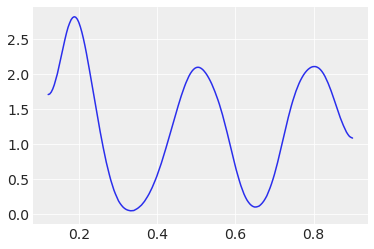

In [63]:
az.plot_kde(df['p'])

In [69]:
with pm.Model() as model:
    mint_idx = pm.Dirichlet('mint_idx', a=np.ones(clusters))
    mint_means = pm.Normal('mint_means', mu=df['p'].mean(), sd=1, shape=clusters)

    # prevent label switching
    order_means = pm.Potential('order_means', tt.switch(mint_means[1]-mint_means[0] < 0, -np.inf, 0))
    sd = pm.HalfNormal('sd', sd=0.1)
    y = pm.NormalMixture('y', w=mint_idx, mu=mint_means, sd=sd, observed=df['p'])

    trace = pm.sample(1000, tune=3000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, mint_means, mint_idx]
Sampling chain 1, 0 divergences: 100%|██████████| 4000/4000 [00:06<00:00, 572.33it/s]


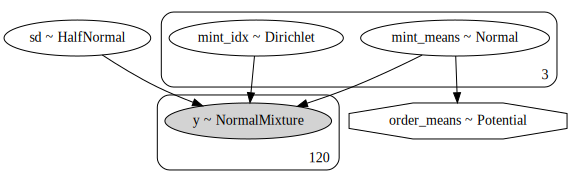

In [70]:
pm.model_to_graphviz(model)

In [71]:
print(az.summary(trace))


                mean     sd  hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
mint_means[0]  0.192  0.007   0.179    0.206  ...  3634.0    3703.0    1568.0    1.0
mint_means[1]  0.798  0.007   0.785    0.812  ...  2971.0    3018.0    1336.0    1.0
mint_means[2]  0.502  0.007   0.489    0.516  ...  2842.0    2840.0    1548.0    1.0
mint_idx[0]    0.334  0.042   0.262    0.418  ...  2726.0    2719.0    1544.0    1.0
mint_idx[1]    0.333  0.041   0.258    0.410  ...  3377.0    3427.0    1724.0    1.0
mint_idx[2]    0.333  0.043   0.251    0.412  ...  3619.0    3923.0    1597.0    1.0
sd             0.046  0.003   0.041    0.052  ...  3331.0    3389.0    1529.0    1.0

[7 rows x 11 columns]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff122268a20>],
      dtype=object)

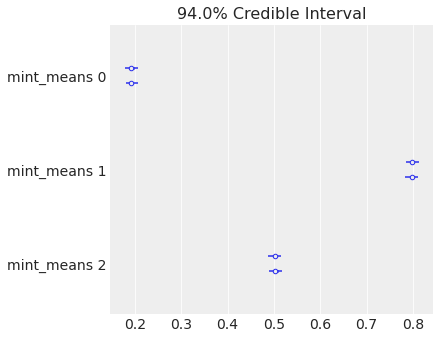

In [72]:
az.plot_forest(trace, var_names='mint_means')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff10e829160>,
      dtype=object)

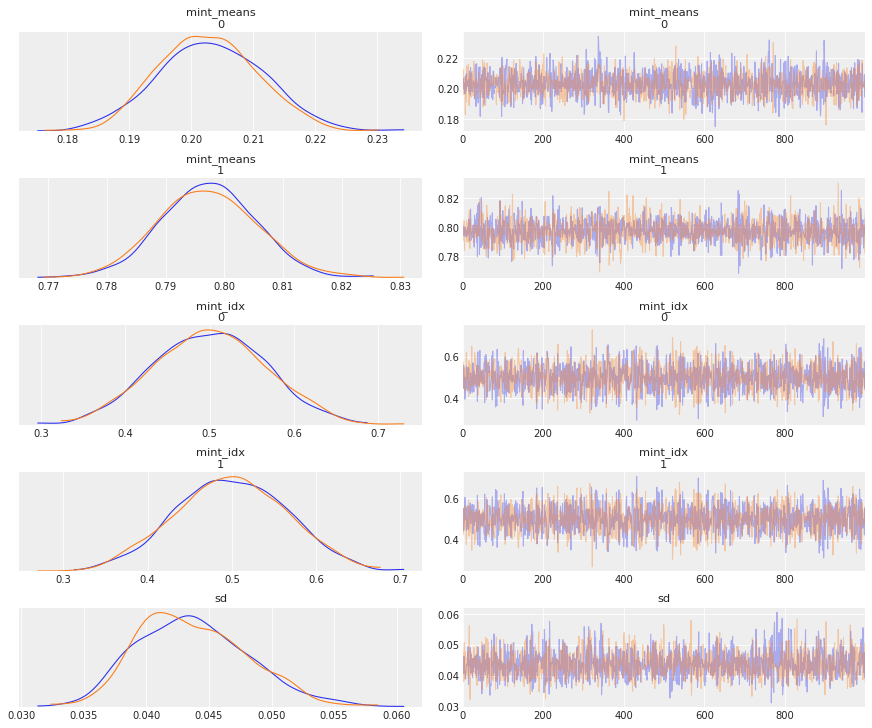

In [33]:
az.plot_trace(trace)